# Dataset Curation

Historical data for BSE Sensex is obtained from [Yahoo Finance](https://finance.yahoo.com/quote/%5EBSESN/history?period1=1420070400&period2=1660003200&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true). 

We entered the start and end dates and copied the entries from the table element on the yahoo finance website and stored them as `yahoo_finance_bse_historical_table.html` file. We will now use beautiful-soup to parse the html table information into a pandas dataframe for subsequent analysis.


In [1]:
# !pip install -q beautifulsoup4 pandas numpy scikit-learn matplotlib seaborn statsmodels pmdarima

In [2]:
# Get all the libraries
import re
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from bs4 import BeautifulSoup

plt.style.use("ggplot")
%matplotlib inline

In [3]:
html_doc = Path("yahoo_finance_bse_historical_table.html").read_text()
soup = BeautifulSoup(html_doc, "html.parser")

# Column Headers
columns = [x.text for x in soup.find("thead").find_all("span")]

# Read the table rows
table_body = soup.find("tbody")
table_rows = table_body.find_all("tr")

# Extract information from each and every individual row
empty_dates = []


def extract_info(row):
    elements = []
    for item in row.find_all("td"):
        if item.span:
            elements.append(item.span.text)
        # In some cases, we have instances of empty rows
        else:
            elements.append("-1")

    elements = [elements[0]] + [float(re.sub(",", "", x)) for x in elements[1:]]

    return elements


# Get all the rows and subsequently create a dataframe
records = [extract_info(x) for x in table_rows]

In [4]:
df = pd.DataFrame(records, columns=columns)
df = df[df.Date != -1].reset_index(drop=True)
df["Date"] = pd.to_datetime(df["Date"])
# Keep only the data till Jun 2021 as that's the range asked for in the question
df = df[df.Date < "07-01-2021"].reset_index(drop=True)
df.tail(10)

,Date,Open,High,Low,Close*,Adj Close**,Volume
1592,2015-01-15,27831.16,28194.61,27703.70,28075.55,28075.55,16700.0
1593,2015-01-14,27432.14,27512.80,27203.25,27346.82,27346.82,10200.0
1594,2015-01-13,27611.56,27670.19,27324.58,27425.73,27425.73,7800.0
1595,2015-01-12,27523.86,27620.66,27323.74,27585.27,27585.27,7500.0
1596,2015-01-09,27404.19,27507.67,27119.63,27458.38,27458.38,11100.0
1597,2015-01-08,27178.77,27316.41,27101.94,27274.71,27274.71,8200.0
1598,2015-01-07,26983.43,27051.60,26776.12,26908.82,26908.82,12200.0
1599,2015-01-06,27694.23,27698.93,26937.06,26987.46,26987.46,14100.0
1600,2015-01-05,27978.43,28064.49,27786.85,27842.32,27842.32,9200.0
1601,2015-01-02,27521.28,27937.47,27519.26,27887.90,27887.90,7400.0


In [5]:
df = df[df["Close*"] != -1].reset_index(drop=True)

Now that we know which dates' data is missing, let's figure out in the Indian Calendar were there any special occasions on these days.

We have now collected data for `BSE Sensex` index right from the year `2015` upto the current day. However, we can truncate the dataset till `June 2021` since the problem statement expects us to only predict till that point in time.

We have the following columns in our dataset

- Date: The date corresponding to which the information is presented
- Open: What was the opening index amount
- High: What was the highest that the index touched for that day
- Low: What was the lowest that the index touched for that day
- Close: What was the closing index amount (Our Prediction Value)
- Volume: An indicator of the amount of trades happening within the given day
- Adj Close: Adjusted close price adjusted for splits/dividends and other capital gain distributions

# Task Definition

We have the information related to BSE Sensex Index from the second of January 2015 to date. We are wanting to predict the close price of the index everyday for the period `Apr' 21 to Jun'21` and using data before that time period to train our model.

The data is collected on a per day basis. Reasons for selecting the granularity as `1 day`:

- The output expects us to predict daily prices in the `April'21 - June'21` Range. So, it makes sense to have the train data at the same granularity as the test data.

- We could also fit an hourly/minutely model and then predict on the last hour/ last minute for the April'21 or June'21 period. However that would make the problem of fetching the data and subsequently processing it very complex. Hence, we chose to restrict ourselves to a per day frequency for this task.

In [6]:
# We want full weeks data hence adjusting the ranges to have Monday-Friday across the entire dataset
df = df.iloc[3:-1, :][::-1]

In [7]:
# Set the index as the date
df.index = df.Date
# df = df.asfreq("B")

## Modelling

We will model this problem as a time-series forecasting problem with `close` as the `label` or target variable.

Since we're modelling the problem as a time-series problem, we can only use

- Historical data about the index

- Exogenous Predictors: Variables which are predetermined and will still impact the index value in the future.

This means, we will not be able to make use of `Open`, `High`, `Low` and `Volume` factors in our analysis.

**Why?**

Because we're assuming we're standing on March 31, 2021 and looking to predict values for April through June 2021. This means no transactions have happened as yet and the values of these features are not yet known to us. We will need to create features that are exogenous.

We already have the date which is a really strong feature. We could extract

- DW: Day of the week
- MM: Month of the year
- QT: Quarter to which the day belongs

Decomposing the date into these three components and treating them as categorical exogenous variables is possible as these values are fixed in the future and there's no uncertainty in these features 

In [8]:
df["DOW"] = df.index.day_name()
df["MOY"] = df.index.month_name()
df["Q"] = df.index.quarter
df["Q"] = df.Q.apply(lambda x: str(x))
df.drop(columns=["Open", "High", "Low", "Adj Close**", "Volume"], inplace=True)

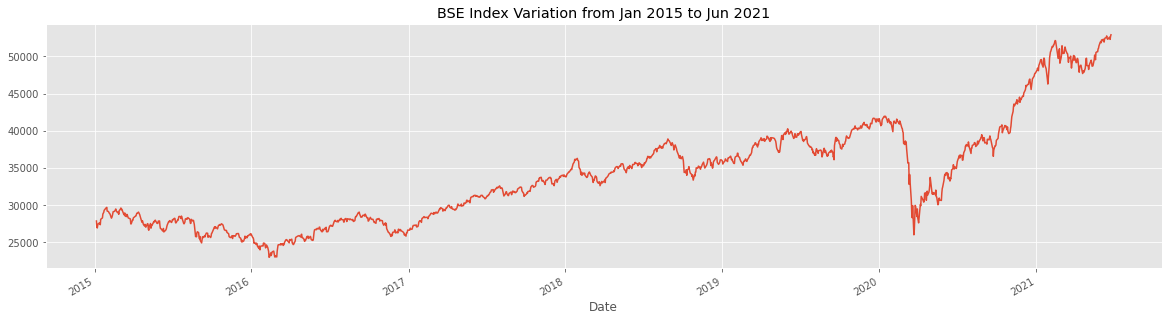

In [9]:
plt.figure(figsize=(20, 5))
df["Close*"].plot()
plt.title("BSE Index Variation from Jan 2015 to Jun 2021");

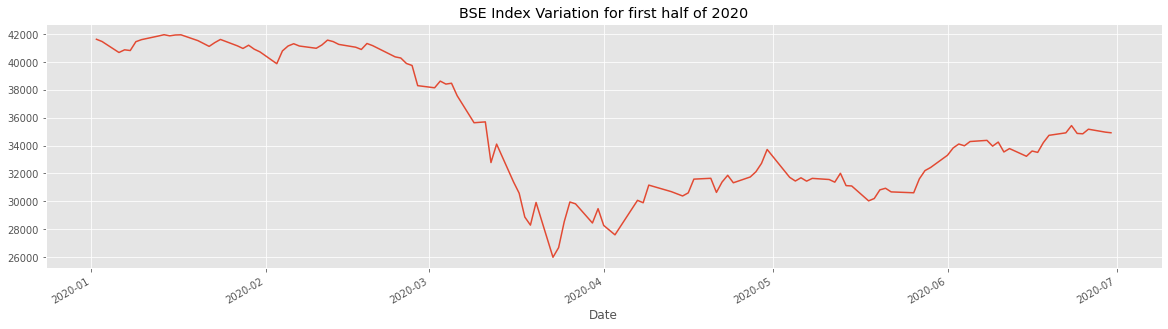

In [10]:
plt.figure(figsize=(20, 5))
df[(df.index > "01-01-2020") & (df.index < "07-01-2020")]["Close*"].plot()
plt.title("BSE Index Variation for first half of 2020");

We can see that the market has over and above continued to rise steadily over time. However there's a huge dip in the period spanning from `Jan 2020 - April 2020`. This is the time when COVID struck adversely and most of the industries and work had come to a standstill. 

Let us try and analyse the `Close` index a little more closely.

We shall decompose the Close index values and assume a seasonality of 5 since we have 5 working days every week.

In [11]:
# fig, ax = plt.subplots(1, 1, figsize = (20,15))
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df["Close*"].values, period=5)

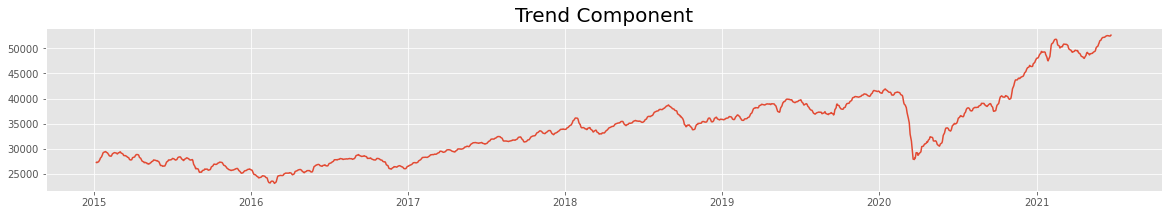

In [12]:
# Look at the trend part of the result
fig, ax = plt.subplots(1, 1, figsize=(20, 3))
plt.plot(df.index.tolist(), result.trend)
plt.title("Trend Component", fontsize=20);

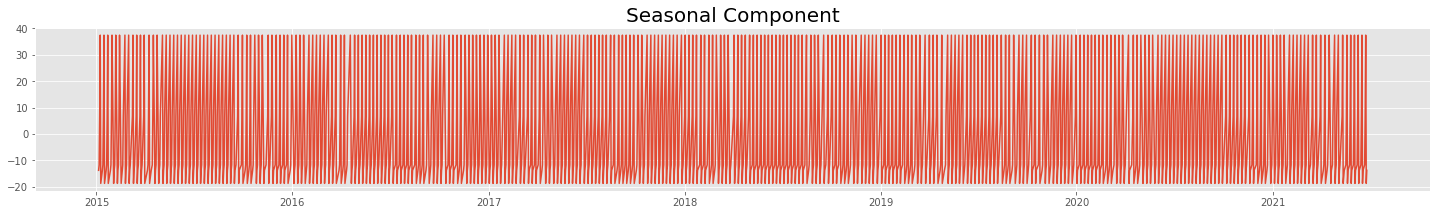

In [13]:
# Look at the seasonal part of the result
fig, ax = plt.subplots(1, 1, figsize=(25, 3))
plt.plot(df.index.tolist(), result.seasonal)
plt.title("Seasonal Component", fontsize=20);

Looking at the plot above, we can say there's a very strong seasonality aspect in the data over a given week. This is to be expected since we know the markets are closed every weekend and there's a weekly seasonality inherent to these index values.

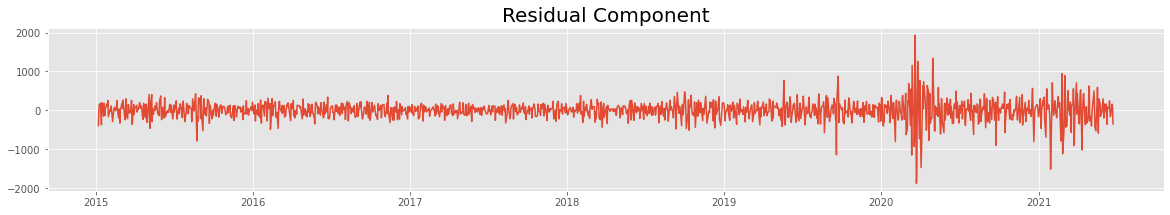

In [14]:
# Look at the residual part of the result
fig, ax = plt.subplots(1, 1, figsize=(20, 3))
plt.plot(df.index.tolist(), result.resid)
plt.title("Residual Component", fontsize=20);

From the residual component part, we can see there are several events which are very interesting.

- In the second half of 2015, there was a noticable dip which could be attributed to fears over slowdown in China.
- In the late 2019, COVID originated in China and there was a substantial movement in the index then.
- In mid-2020, COVID hit India adversely at it's worst and the residual in the index reflects that motion very visibly.
- In the early half of 2021, subsequent waves of COVID hit India adversely leading to a high unpredictability in the market index.

Now that we have some knowledge about the index movement, let us preprocess the dataset (i.e. handle categorical variables) so that we can build a `SARIMAX` model out of it.

We can handle these variables by using OneHotEncoder from sklearn or the get_dummies function from pandas.

In [15]:
from sklearn.preprocessing import OneHotEncoder

# Use the OneHotEncoder from sklearn, drop the first level in any given category
# This is to ensure no multicollinearity/redundancy in the column-space
OHE = OneHotEncoder(handle_unknown="ignore", drop="first")
cat_cols = ["DOW", "MOY", "Q"]
OHE.fit(df[cat_cols])
df_categorical = pd.DataFrame(
    OHE.transform(df[cat_cols]).toarray(),
    columns=OHE.get_feature_names_out(),
    index=df.index,
)
df_categorical.head(2)

,DOW_Monday,DOW_Thursday,DOW_Tuesday,DOW_Wednesday,MOY_August,MOY_December,MOY_February,MOY_January,MOY_July,MOY_June,MOY_March,MOY_May,MOY_November,MOY_October,MOY_September,Q_2,Q_3,Q_4
Date,,,,,,,,,,,,,,,,,,
2015-01-05,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-06,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
final_df = pd.concat([df, df_categorical], axis=1)
final_df.drop(columns=["DOW", "MOY", "Q", "Date"], inplace=True)
final_df.head(3)

,Close*,DOW_Monday,DOW_Thursday,DOW_Tuesday,DOW_Wednesday,MOY_August,MOY_December,MOY_February,MOY_January,MOY_July,MOY_June,MOY_March,MOY_May,MOY_November,MOY_October,MOY_September,Q_2,Q_3,Q_4
Date,,,,,,,,,,,,,,,,,,,
2015-01-05,27842.32,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-06,26987.46,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-07,26908.82,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Create an auto-arima model and figure out the AR, D, MA, Seasonal components and then fit a model.

In [17]:
from pmdarima import auto_arima

auto_arima(df["Close*"], seasonal=True, m=5).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1591
Model:             SARIMAX(2, 1, 2)x(1, 0, [1], 5)   Log Likelihood              -11695.078
Date:                             Wed, 10 Aug 2022   AIC                          23406.156
Time:                                     22:15:42   BIC                          23449.127
Sample:                                          0   HQIC                         23422.117
                                            - 1591                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     16.1094     24.080      0.669      0.503     -31.086      63.305
ar.L1         -1.4691      0.016    -94.039      0.000      -1.500      -1.438
ar.L2         -0.9344      0.014    -65.668      0.000      -0.962      -0.907
ma.L1          1.4615      0.014    105.140      0.000       1.434       1.489
ma.L2          0.9634      0.014     68.388      0.000       0.936       0.991
ar.S.L5        0.4081      0.177      2.300      0.021       0.060       0.756
ma.S.L5       -0.3324      0.181     -1.833      0.067      -0.688       0.023
sigma2      1.469e+05   2461.708     59.692      0.000    1.42e+05    1.52e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.58   Jarque-Bera (JB):              8816.39
Prob(Q):                              0.45   Prob(JB):                         0.00
Heteroskedasticity (H):               4.48   Skew:                            -0.70
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""